In [41]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

In [43]:
df.shape

(329064, 90)

In [44]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'], format='%d/%m/%y')
df['date_sortie_defaut'] = pd.to_datetime(df['date_sortie_defaut'], format='%d/%m/%y', errors='coerce')
df['arrete'] = pd.to_datetime(df['arrete'], format='%d/%m/%y')
df['DT_MEP_OPE'] = pd.to_datetime(df['DT_MEP_OPE'], format='%d%b%Y:%H:%M:%S.%f')
df['dt_arr_last_enc_ope'] = pd.to_datetime(df['dt_arr_last_enc_ope'], errors='coerce')
df['dt_arr_1st_enc_ope'] = pd.to_datetime(df['dt_arr_1st_enc_ope'], errors='coerce')
df['dtHJD_prov'] = pd.to_datetime(df['dtHJD_prov'], errors='coerce')
df['dtHJD_def'] = pd.to_datetime(df['dtHJD_def'], errors='coerce')

In [45]:
for column in df.columns :
    if df[column].isna().sum()/df.shape[0] > 0.5 : 
        df.drop(columns = [column], inplace = True)

In [46]:
df.drop(columns = ["CD_POST_BIEN_PFI"], inplace = True)

In [47]:
cols_numeriques = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cols_categorielles = df.select_dtypes(include=['object']).columns.to_list()
cols_categorielles.remove("cd_op")

for col in cols_numeriques:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cols_categorielles:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [48]:
df_validation = df[df['arrete']>"2020-12-30"]
df_train = df[df['arrete']<"2020-12-30"]
df_train = df_train.reset_index()

In [73]:
liste_var = ['cd_op','fl_pass_DET','arrete','date_entree_defaut','fam_ENQ','solution','FL_REL_NON_ANNULE','niv_gravite_mtf_dne','CD_SITFAM_EMP1','regroup_natur_op','PTG','fl_fam_vam','fam_PCD','AMI','CD_ETAT_CIVIL','CD_NAT_EMP1','niv_gravite_mtf_dne','FL_REL_NON_ANNULE','sol_echec','fl_def_ss_pass_CTX','nb_empr_ope','CD_MTF_DFC','FL_ETR','dls_ges_def']
liste_var = ['cd_op','fl_pass_DET','arrete','date_entree_defaut','dls_ges_def']

In [74]:
df_train_var = df[liste_var].copy()
df_test_var = df_validation[liste_var].copy()

# Visualisation des variables qui bougent dans le temps 

In [75]:
id_list = list(df['cd_op'].unique()[:15])
liste_var_temp = []

for id in id_list:
    print(f"Identifiant : {id} :")
    for col in df.drop(columns = ['arrete','cum_rec','cum_dec']).columns:
        if df[df['cd_op'] == id ][col].nunique() >1:
            print(f"{col} : {df[df['cd_op'] == id ][col].nunique()}")
            liste_var_temp.append(col)
        else:
            pass
liste_var_temp = set(liste_var_temp)
liste_var_temp = list(liste_var_temp)
liste_var_temp

Identifiant : I860708600 :
MT_EAD_RESID : 2
dls_ges_def : 11
AGE_EMP1 : 2
AGE_EMP2 : 2
Identifiant : I950404213 :
MT_EAD_RESID : 2


KeyboardInterrupt: 

# Selection des individus réellement censurés et des fl_pass_DET=1

In [76]:
df_train_var.index = df_train_var['cd_op'] # etape temporaire pour récupérer les cd_op plus facielement
df_test_var.index = df_test_var['cd_op']

In [77]:
liste_target_1 = df_train_var[df_train_var['fl_pass_DET']==1].index.to_list() # on récupère les données non censurées
liste_target_1_test = df_test_var[df_test_var['fl_pass_DET']==1].index.to_list()

In [78]:
liste_target_censure = df_train_var[df_train_var['arrete']=='2022-12-31'].index.to_list() # on recupère les id censurés
liste_target_censure_test = df_test_var[df_test_var['arrete']=='2022-12-31'].index.to_list()

In [79]:
liste_target_censure.extend(liste_target_1) # on combine les 2 listes
liste_target_censure_test.extend(liste_target_1_test)

In [80]:
liste_cd_op = set(liste_target_censure) # on supprime les doublons
liste_cd_op = list(liste_cd_op)

liste_cd_op_test = set(liste_target_censure_test) # on supprime les doublons
liste_cd_op_test = list(liste_cd_op_test)

In [81]:
len(liste_cd_op) # On a donc 11301 individus à traiter dans notre base de données

11301

In [82]:
len(liste_cd_op_test)

6295

In [83]:
data = df_train_var[df_train_var['cd_op'].isin(liste_cd_op)]
data_test = df_test_var[df_test_var['cd_op'].isin(liste_cd_op_test)]

data_test.shape

(72420, 5)

# Encoding

In [84]:
def encode_columns(df):
    encoders = {}
    for column in df.select_dtypes(include='object'):
        unique_values = df[column].nunique()
        if unique_values <= 10:
            # Appliquer OneHotEncoder
            encoder = OneHotEncoder(sparse=False)
            encoded = encoder.fit_transform(df[[column]])
            encoders[column] = encoder

            # Remplacer la colonne originale par de nouvelles colonnes pour chaque catégorie
            for i, category in enumerate(encoder.categories_[0]):
                df[str(column) + '_' + str(category)] = encoded[:, i]
            df.drop(column, axis=1, inplace=True)
        else:
            # Appliquer LabelEncoder
            encoder = LabelEncoder()
            df[column] = encoder.fit_transform(df[column])
            encoders[column] = encoder
    return df, encoders

encoded_df, encoders = encode_columns(data.drop(columns = ['cd_op','fl_pass_DET','arrete','date_entree_defaut']))
encoded_test, encoder_test = encode_columns(data_test.drop(columns = ['cd_op','fl_pass_DET','arrete','date_entree_defaut']))

In [85]:
encoded_df['cd_op']  = data.index
encoded_df['fl_pass_DET'] = data['fl_pass_DET'].copy()
encoded_df['date_entree_defaut'] = data['date_entree_defaut'].copy()
encoded_df['arrete'] = data['arrete'].copy()

In [86]:
encoded_test['cd_op']  = data_test['cd_op'].copy()
encoded_test['fl_pass_DET'] = data_test['fl_pass_DET'].copy()
encoded_test['date_entree_defaut'] = data_test['date_entree_defaut'].copy()
encoded_test['arrete'] = data_test['arrete'].copy()

# DataPrep

In [87]:
data_haz = encoded_df.copy()
data_test =encoded_test.copy()

In [88]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].dt.days

data_test['start'] = 0
data_test['stop'] = data_test['arrete'] - data_test['date_entree_defaut']
data_test['stop'] = data_test['stop'].dt.days

In [89]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))


data_test['id'] = data_test['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [90]:
data_haz.id = data_haz.id.astype('int')

In [91]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'fl_pass_DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

data_test.loc[(data_test['start'] == data_test['stop']) & (data_test['start'] == 0) & data_test[
    'fl_pass_DET'], 'stop'] = 0.5 

In [92]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])

data_test = data_test.select_dtypes(exclude=["datetime64"])

In [93]:
data_haz.drop(columns = ["cd_op"], inplace = True)


data_test.drop(columns = ["cd_op"], inplace = True)

In [94]:
data_haz.drop(columns = ['FL_REL_NON_ANNULE', 'niv_gravite_mtf_dne', 'niv_gravite_mtf_dne'],inplace = True)

KeyError: "['FL_REL_NON_ANNULE', 'niv_gravite_mtf_dne', 'niv_gravite_mtf_dne'] not found in axis"

# Modelisation

In [95]:
ctv = CoxTimeVaryingFitter(penalizer=0.2)
ctv.fit(data_haz, id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True)

Iteration 1: norm_delta = 1.69e-01, step_size = 0.9500, log_lik = -82428.72295, newton_decrement = 6.73e+02, seconds_since_start = 4.2
Iteration 2: norm_delta = 1.23e-02, step_size = 0.9500, log_lik = -81748.72266, newton_decrement = 3.42e+00, seconds_since_start = 8.5
Iteration 3: norm_delta = 6.32e-04, step_size = 0.9500, log_lik = -81745.30410, newton_decrement = 9.01e-03, seconds_since_start = 12.7
Iteration 4: norm_delta = 3.33e-05, step_size = 1.0000, log_lik = -81745.29511, newton_decrement = 2.26e-05, seconds_since_start = 17.0
Iteration 5: norm_delta = 1.15e-10, step_size = 1.0000, log_lik = -81745.29509, newton_decrement = 2.68e-16, seconds_since_start = 21.3
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 175878 periods, 11301 subjects, 7463 events>

In [96]:
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 175878 periods, 11301 subjects, 7463 events>
         event col = 'fl_pass_DET'
         penalizer = 0.2
number of subjects = 11301
 number of periods = 175878
  number of events = 7463
partial log-likelihood = -81745.30
  time fit was run = 2024-01-20 12:13:33 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
dls_ges_def  -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99

              cmp to      z      p   -log2(p)
covariate                                    
dls_ges_def     0.00 -36.72 <0.005     978.24
---
Partial AIC = 163492.59
log-likelihood ratio test = 1366.86 on 1 df
-log2(p) of ll-ratio test = 991.51

<Axes: xlabel='log(HR) (95% CI)'>

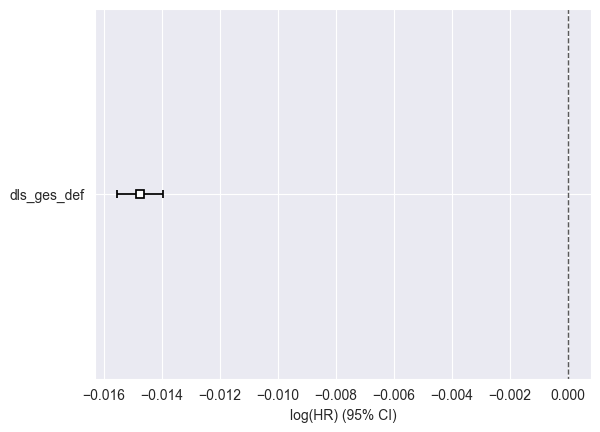

In [97]:
ctv.plot()

In [33]:
predictions = ctv.predict_partial_hazard(data_test)

In [34]:
predictions = pd.DataFrame(predictions)
predictions['id']= data_test['id'].index
predictions.rename(columns = {0:'pred'},inplace = True)

# Representaitons graphiques

In [35]:
(predictions['pred'].max())

3.0995081218778444

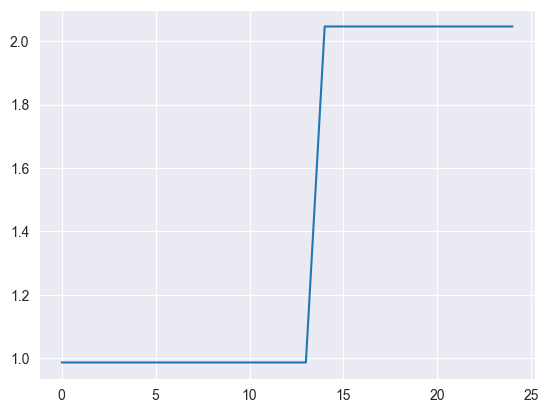

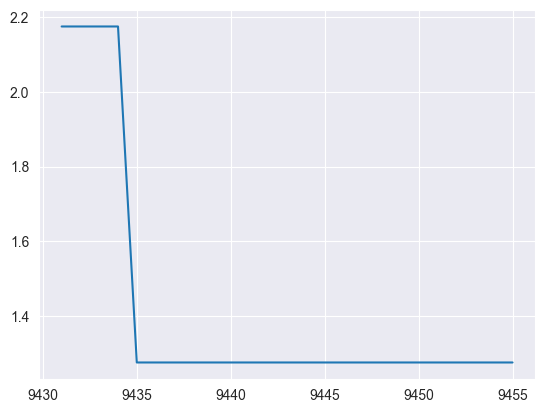

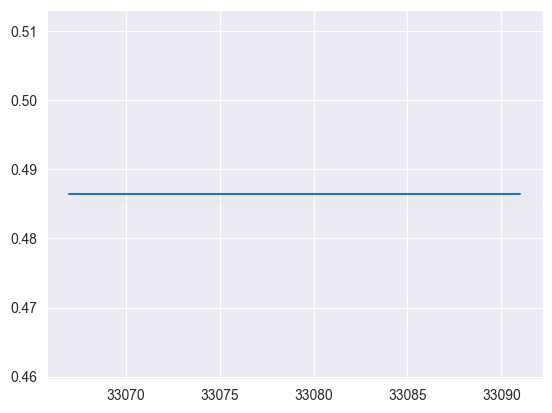

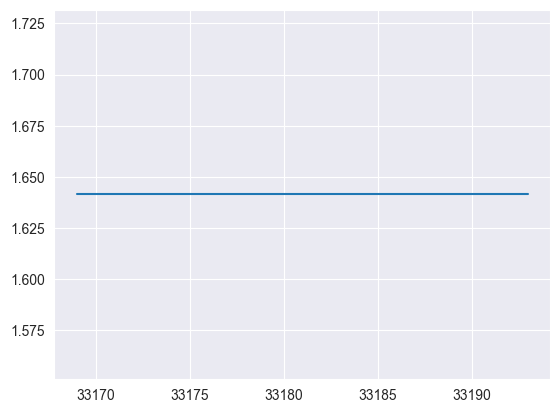

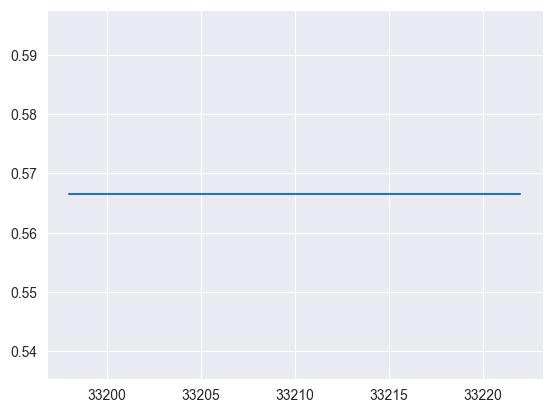

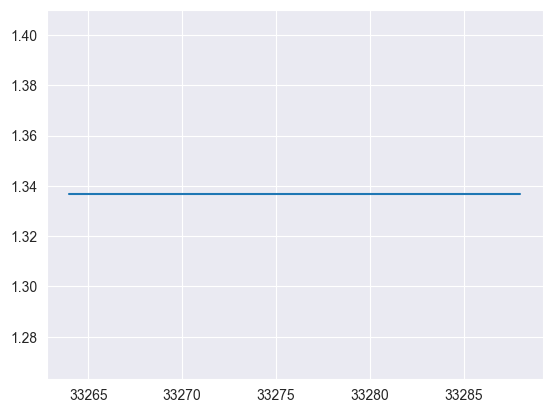

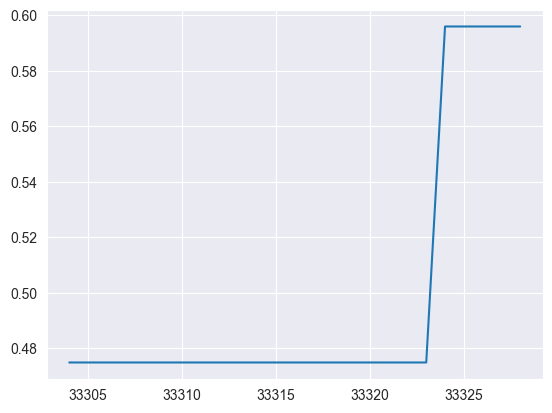

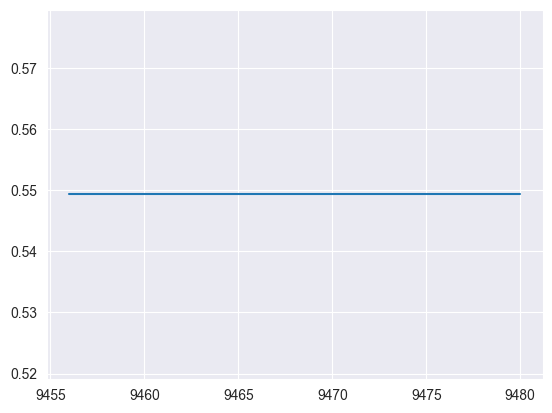

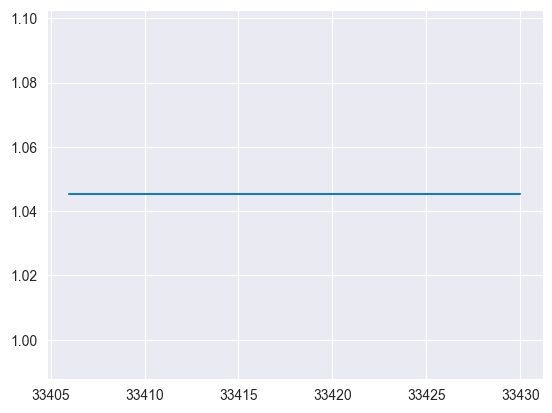

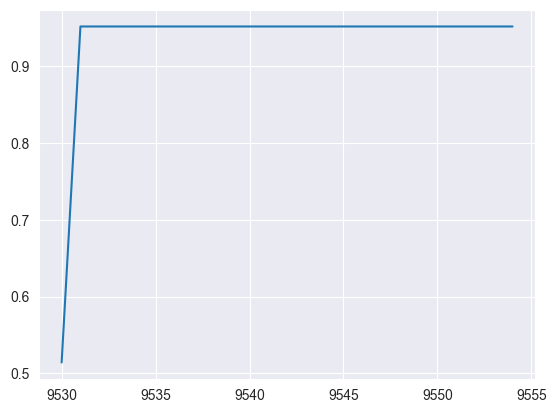

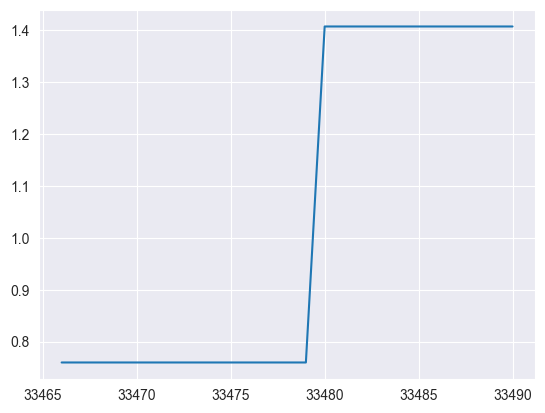

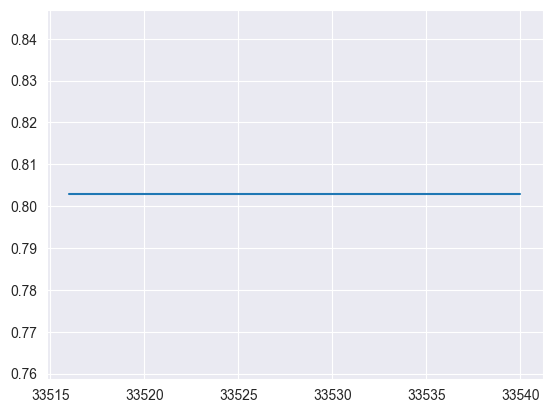

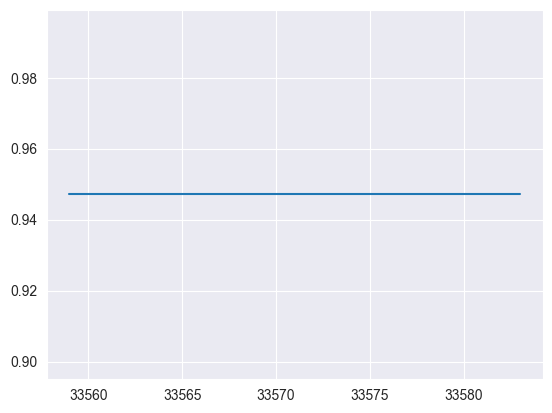

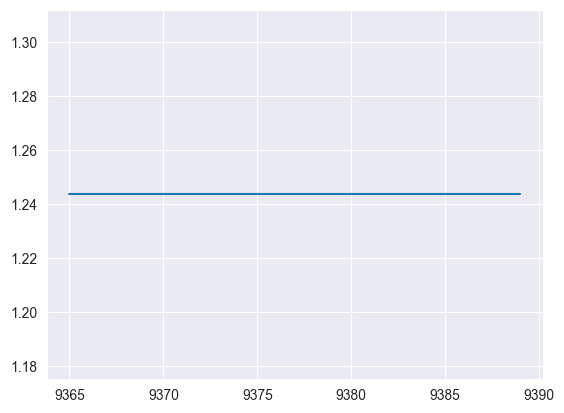

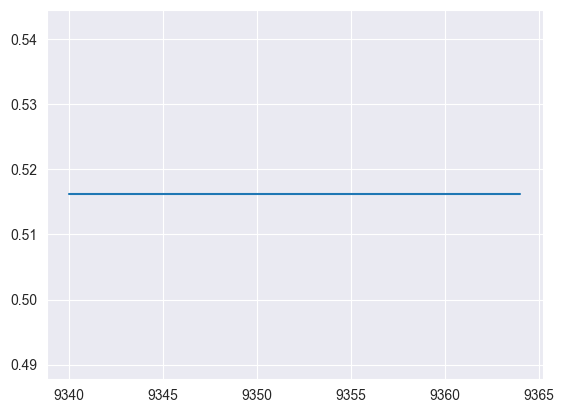

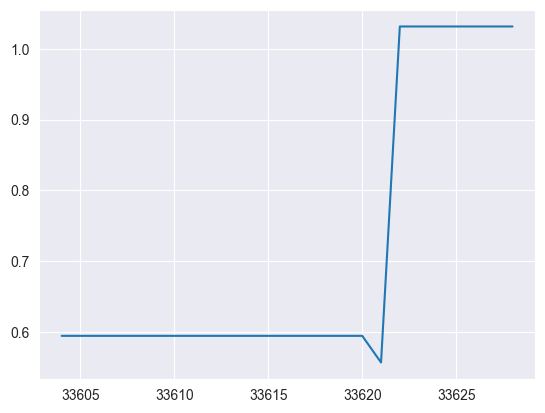

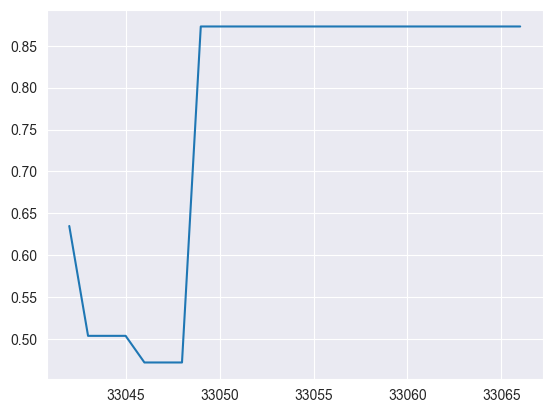

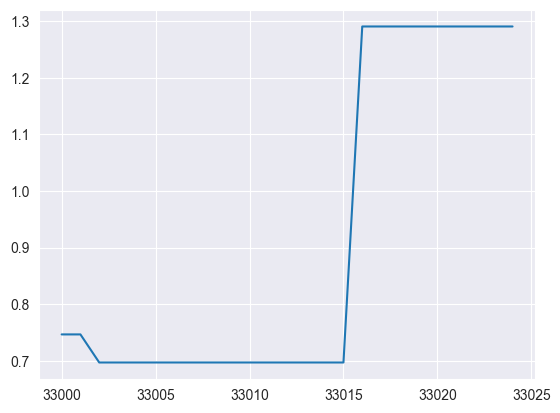

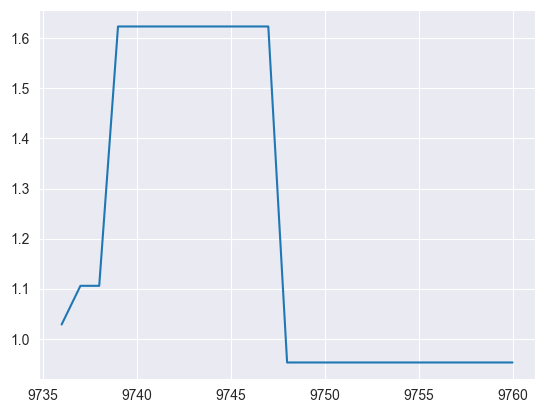

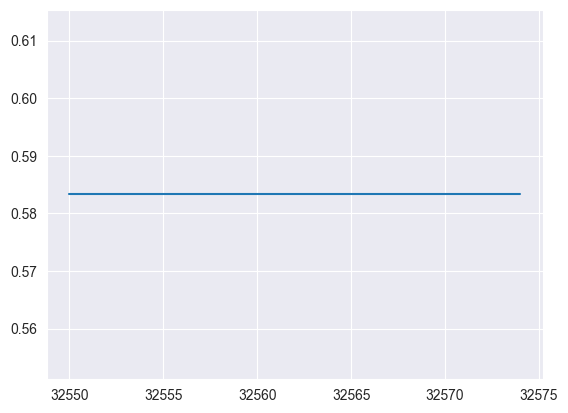

In [36]:
liste_var_plot = ['I990802466', 'M070659197', 'M111025274', 'M111081585', 'M111082867', 'M111087152', 'M111087892', 'M070660069', 'M111112642', 'M070672733', 'M111119798', 'M111121917', 'M111123387', 'M070646466', 'M070646133', 'M111129039', 'M111025211', 'M111023950', 'M070749994', 'M110926774']

for id in liste_var_plot:
    plt.plot(predictions[predictions['id'] == id ]['pred'])
    plt.show()

On va drop fam_enq et cd_etat_civil car cd_etat_civil est non significative et fam_enq a l'air de faire buguer le modèle

#### Tests pour voir quelles var soont problematiques

fl_def_ss_pass_CTX
Iteration 1: norm_delta = 4.24e-02, step_size = 0.9500, log_lik = -82428.72295, newton_decrement = 3.12e+01, seconds_since_start = 4.4
Iteration 2: norm_delta = 6.21e-03, step_size = 0.9500, log_lik = -82396.07437, newton_decrement = 5.71e-01, seconds_since_start = 9.0
Iteration 3: norm_delta = 3.78e-04, step_size = 0.9500, log_lik = -82395.50107, newton_decrement = 2.08e-03, seconds_since_start = 13.5
Iteration 4: norm_delta = 2.02e-05, step_size = 1.0000, log_lik = -82395.49900, newton_decrement = 5.31e-06, seconds_since_start = 18.0
Iteration 5: norm_delta = 6.52e-10, step_size = 1.0000, log_lik = -82395.49900, newton_decrement = 5.55e-15, seconds_since_start = 22.6
Convergence completed after 5 iterations.
nb_empr_ope
Iteration 1: norm_delta = 3.51e-02, step_size = 0.9500, log_lik = -82428.72295, newton_decrement = 1.73e+01, seconds_since_start = 4.1
Iteration 2: norm_delta = 1.84e-03, step_size = 0.9500, log_lik = -82411.42789, newton_decrement = 4.72e-02, secon

KeyError: "['CD_NAT_EMP1_ZZZ'] not in index"

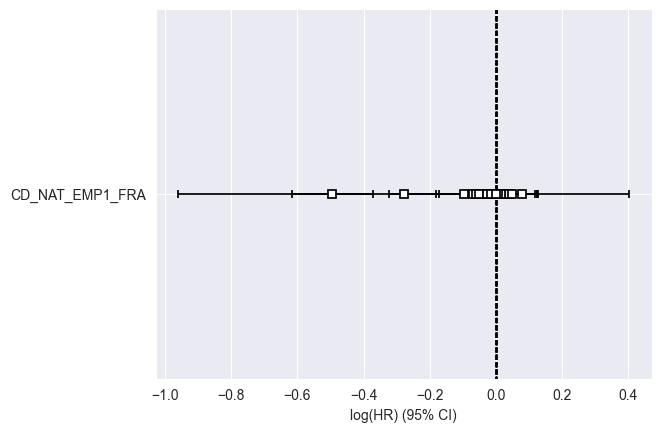

In [37]:
for col in [ 'fl_def_ss_pass_CTX',
       'nb_empr_ope', 'CD_MTF_DFC', 'FL_ETR', 'CD_SITFAM_EMP1_C',
       'CD_SITFAM_EMP1_D', 'CD_SITFAM_EMP1_I', 'CD_SITFAM_EMP1_M',
       'CD_SITFAM_EMP1_S', 'CD_SITFAM_EMP1_U', 'CD_SITFAM_EMP1_V',
       'regroup_natur_op_1_neuf_aco_acr', 'regroup_natur_op_2_rachat_sou',
       'regroup_natur_op_3_travaux', 'regroup_natur_op_4_autre',
       'CD_NAT_EMP1_CDT', 'CD_NAT_EMP1_CEE', 'CD_NAT_EMP1_ETR',
       'CD_NAT_EMP1_FRA', 'CD_NAT_EMP1_ZZZ', 'sol_echec_0_0', 'sol_echec_0_1',
       'sol_echec_1_0', 'sol_echec_1_1'] : 
    print(f"{col}")
    ctv3 = CoxTimeVaryingFitter(penalizer=0.1)
    ctv3.fit(data_haz[[col,'id','fl_pass_DET','stop','start']], id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True, start_col='start')
    ctv3.plot()

liste var problematiques : FL_REL_NON_ANNULE, 'niv_gravite_mtf_dne' 'niv_gravite_mtf_dne'

# Test CoxPHFitter

In [ ]:
data_haz.head(30)

In [ ]:
data_cox = data_haz.drop_duplicates(subset = "id",keep = 'last') # on retire les doublons
test_cox = data_test.drop_duplicates(subset = "id",keep = 'last') # on retire les doublons
test_cox.drop(columns = ['start','fl_pass_DET', 'id'],inplace = True )

In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)  # Choisir le paramètre de pénalité
cph.fit(data_haz.drop(columns = ['id','start']), duration_col='stop', event_col='fl_pass_DET')


In [ ]:
predictions = cph.predict_survival_function(test_cox)


In [ ]:
predictions = predictions.transpose()

In [ ]:
predictions.shape

In [ ]:
survival_function_observation_0 = predictions.iloc[1880]

# Tracer la fonction de survie pour l'observation 0
survival_function_observation_0.plot()
plt.show()

In [ ]:
cph.predict_